# EPO4 Assignment: ECG Preprocessing and Feature Extraction 

## Dataset: WESAD

please note that below are some simple techniques to get you started with processing ECG signals. After completening this assighnment you are free to choose you own approach and algorithms for the project.

## Dowload and read the data

To download the data go to [here](https://ubicomp.eti.uni-siegen.de/home/datasets/icmi18/), click on link in the download section. More information on dataset can be found[here](https://archive.ics.uci.edu/ml/datasets/WESAD+%28Wearable+Stress+and+Affect+Detection%29). If you are working in colab, an easy way to have access to the dataset is to upload it to you google drive. Go to [My Drive](https://drive.google.com/drive/my-drive) and use "new > folder upload" and upload the unzipped folder. Once the folder is uploaded you can read its files from colab. You only need to mount google drive on colab notebook every time you open your notebook. To do so,  go to "Files" on the vertical tab menu on right and click on "Mount Drive".

In [36]:
import os
import pickle
import numpy as np
from scipy import signal
from scipy.signal import butter, iirnotch, lfilter
import numpy as np
import matplotlib.pyplot as plt

In [37]:
'''from google.colab import drive
drive.mount('/content/drive', force_remount=True)'''

"from google.colab import drive\ndrive.mount('/content/drive', force_remount=True)"

We need to define the dataset path and the subject ID

In [38]:
data_set_path = "D:\Downloads\WESAD\WESAD\\"
subject = 'S2'

The class below allows you to access all the recordings and labels in the dataset.

In [39]:
class read_data_of_one_subject:
    """Read data from WESAD dataset"""
    def __init__(self, path, subject):
        self.keys = ['label', 'subject', 'signal']
        self.signal_keys = ['wrist', 'chest']
        self.chest_sensor_keys = ['ACC', 'ECG', 'EDA', 'EMG', 'Resp', 'Temp']
        self.wrist_sensor_keys = ['ACC', 'BVP', 'EDA', 'TEMP']
        #os.chdir(path)
        #os.chdir(subject)
        with open(path + subject +'/'+subject + '.pkl', 'rb') as file:
            data = pickle.load(file, encoding='latin1')
        self.data = data

    def get_labels(self):
        return self.data[self.keys[0]]

    def get_wrist_data(self):
        """"""
        #label = self.data[self.keys[0]]
        assert subject == self.data[self.keys[1]]
        signal = self.data[self.keys[2]]
        wrist_data = signal[self.signal_keys[0]]
        #wrist_ACC = wrist_data[self.wrist_sensor_keys[0]]
        #wrist_ECG = wrist_data[self.wrist_sensor_keys[1]]
        return wrist_data

    def get_chest_data(self):
        """"""
        signal = self.data[self.keys[2]]
        chest_data = signal[self.signal_keys[1]]
        return chest_data

In [40]:
# Object instantiation
obj_data = {}
 
# Accessing class attributes and method through objects
obj_data[subject] = read_data_of_one_subject(data_set_path, subject)

The code below allows you to read and print the length of all biosignals from the chest recording device recorded all at 700 Hz.

In [41]:
chest_data_dict = obj_data[subject].get_chest_data()
chest_dict_length = {key: len(value) for key, value in chest_data_dict.items()}
print(chest_dict_length)

{'ACC': 4255300, 'ECG': 4255300, 'EMG': 4255300, 'EDA': 4255300, 'Temp': 4255300, 'Resp': 4255300}


You can also access the labels of each class. The following labels are provided: 0 = not defined / transient, 1 = baseline, 2 = stress, 3 = amusement, 4 = meditation, 5/6/7 = should be ignored in this dataset.

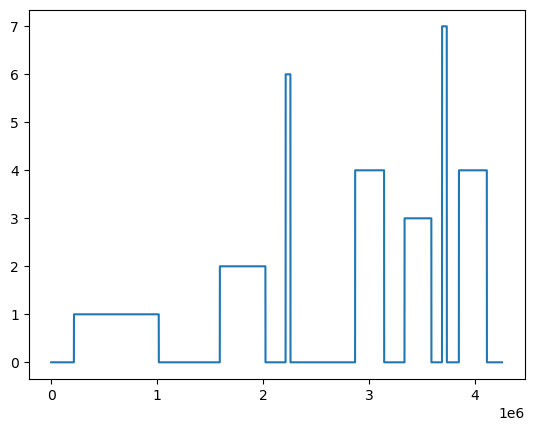

In [42]:
# Get labels
labels = obj_data[subject].get_labels() 
baseline = np.asarray([idx for idx,val in enumerate(labels) if val == 1])
plt.plot(labels)

Let's load some part of the ECG signal during baseline recording

Text(0, 0.5, '$ECG$')

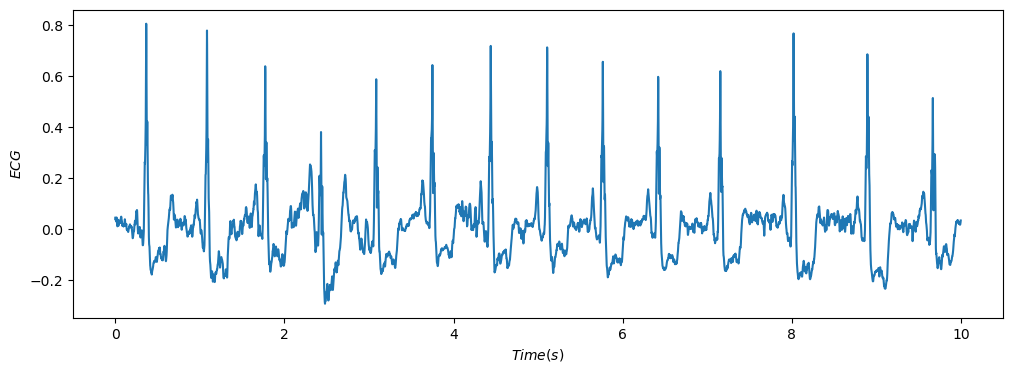

In [43]:
ecg_base=chest_data_dict['ECG'][baseline,0]
fs=700
# cut a smaller window
ecg=ecg_base[10000:10000+ 10*fs]

t=np.arange(0,ecg.size*(1/fs),(1/fs))
t=t[:ecg.size]

plt.figure(figsize=(12,4))
plt.plot(t,ecg)
plt.xlabel('$Time (s)$') 
plt.ylabel('$ECG$') 

## Filtering 
Below you can see how we can perform highpass, low pass and noth filtering on ECG recordings.

For the highpass and lowpass filter we use a 5th order digital butterworth with a normalized frequency, and output set to `output='ba'`. For the nuch filter we use the second-order IIR notch digital filter with `Q=30`.

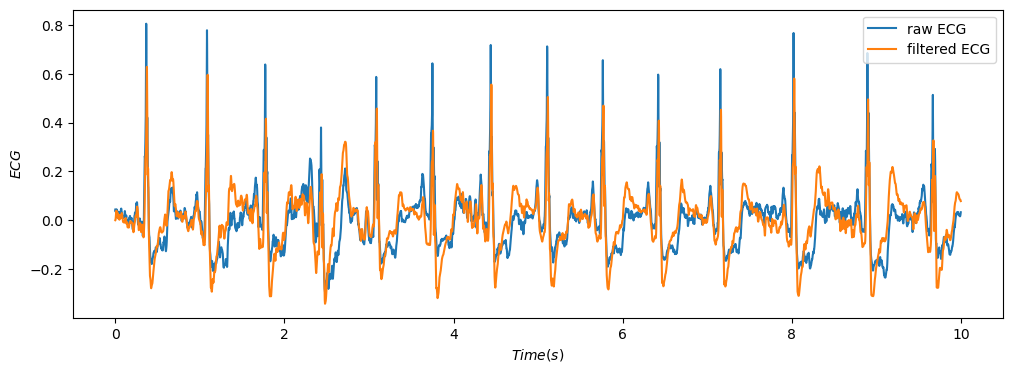

In [44]:
nyq = 0.5*fs
order=5

# highpass filter
high=0.5
high= high/nyq
b, a = butter(order, high, btype= 'highpass')
ecg_h = lfilter(b,a,ecg)

# lowpass filter
low=70
low= low/nyq
b, a = butter(order, low)
ecg_hl = lfilter(b,a,ecg_h)

# notch filter
notch=50
notch = notch/nyq
b, a = iirnotch(notch, 30, fs=fs)
ecg_hln = lfilter(b,a,ecg_hl)


plt.figure(figsize=(12,4))
plt.plot(t,ecg,label="raw ECG")
plt.plot(t,ecg_hln, label="filtered ECG")
plt.xlabel('$Time (s)$') 
plt.ylabel('$ECG$') 
plt.legend()

## R peak Detection
You can either develope your own code for r-peak detection or use the pan-tompkin approach for that. Pan-tompkins does some filtering on the data itself so you can just pass the raw data to it.

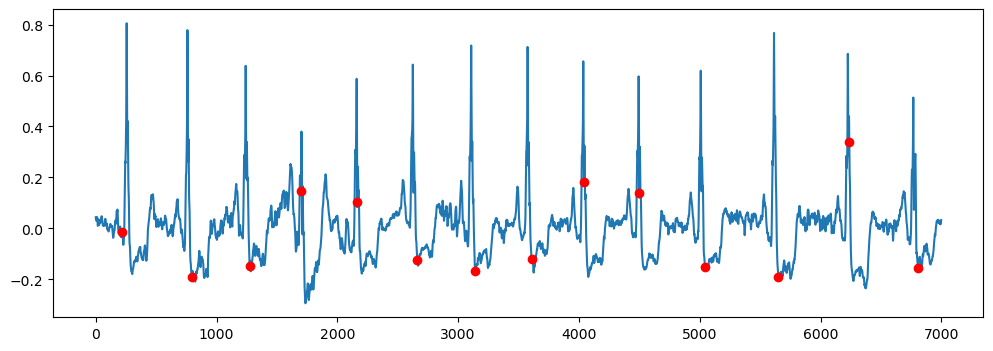

In [47]:
# detect R-peaks
from ecgdetectors import Detectors
detectors = Detectors(fs)

r_peaks_pan = detectors.pan_tompkins_detector(ecg_hln)
r_peaks_pan = np.asarray(r_peaks_pan)

plt.figure(figsize=(12,4))
plt.plot(ecg)
plt.plot(r_peaks_pan,ecg[r_peaks_pan], 'ro')

Here is also some example feature you can extract using ecgdetectors 

In [50]:
from hrv import HRV   # to import the module
hrv_class = HRV(fs)

feat_nn20=hrv_class.NN20(r_peaks_pan)
feat_nn50=hrv_class.NN50(r_peaks_pan)
   